**Members: Minh Tran Quoc, Melody Yu, Eric Salguero, Danh Nguyen**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
from google.colab import files
#added some below check if correct
from sklearn.model_selection import train_test_split
%matplotlib inline

### Loading Data

In [ ]:
# Upload the pokemon file (only once)
uploaded = files.upload()

print(uploaded)

pokemon_fn = None

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  pokemon_fn = fn

In [3]:
# Load the uploaded file
df = pd.read_csv(pokemon_fn)
df.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


### Data Cleaning

In [6]:
# Rename the columns for easier access 
df.columns = ['id', 'name', 'type1', 'type2', 'total', 'hp', 'attack', 'defense', 's.attack', 's.defense', 'speed', 'gen', 'legendary']
df.head()


,id,name,type1,type2,total,hp,attack,defense,s.attack,s.defense,speed,gen,legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [0]:
# First, we filter out columns we don't need
df = df[['total', 'hp', 'attack', 'defense', 's.attack', 's.defense', 'speed', 'gen']]

# Then we check if there is any missing entries in the columns we are interested
df.isnull().any()

total        False
hp           False
attack       False
defense      False
s.attack     False
s.defense    False
speed        False
gen          False
dtype: bool

Looks like there are no null values.

### Data Visualization

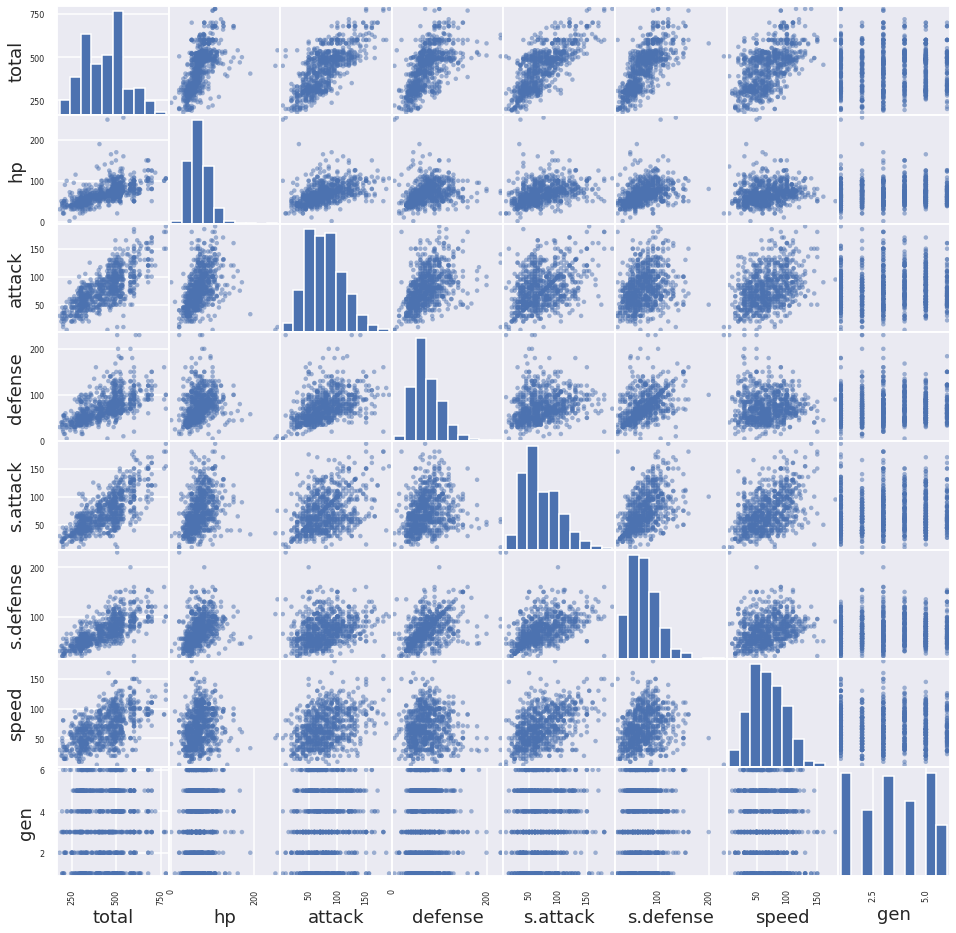

In [0]:
# First, a scatter matrix to see if there is any obvious correlation between statistics
fig = pd.plotting.scatter_matrix(df, figsize=(16,16))

From the above pair-wise scatter matrix of the columns, we observe a few things:
- Total is positively correlated with any other stats. This makes sense, since total is  the sum of all the stats.
- Most stats are positively correlated with each other. It seems that pokemons with more of a particular stat often have more of other stats.

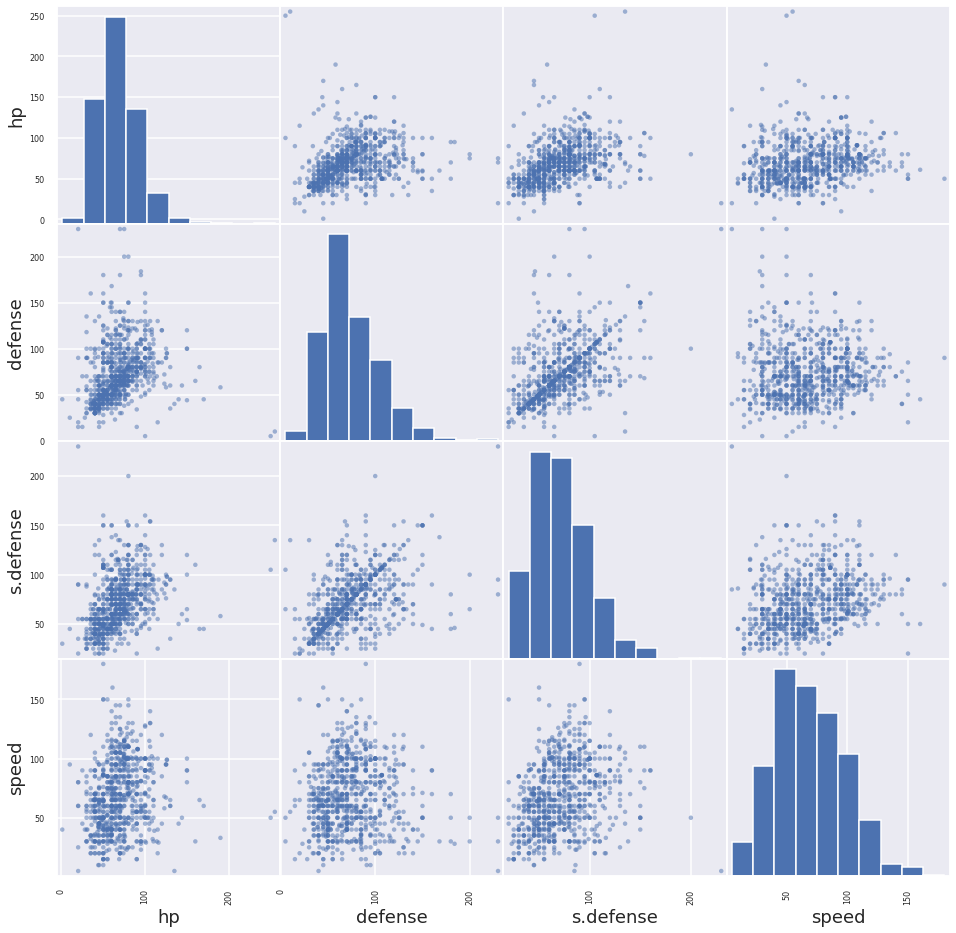

In [7]:
#Then, filter columns to only the defensive statistics. Observe their correlations
df = df[['hp', 'defense', 's.defense', 'speed']]
fig = pd.plotting.scatter_matrix(df, figsize=(16,16))

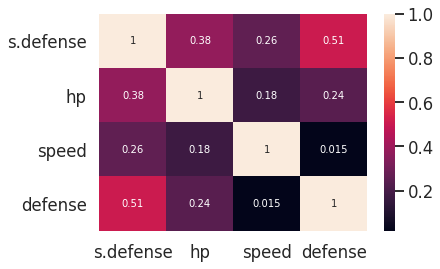

In [0]:
#plot a heatmap to see actual correlation values
f = (
    df.loc[:, ['s.defense', 'hp', 'speed', 'defense']]
).corr()

sns.heatmap(f, annot=True)


### Primary Analysis

In [0]:
sDefense = df['s.defense'].values
hp = df['hp'].values
defense = df['defense'].values
speed = df['speed'].values

Split the data into three training/testing sets, but use the same seed for each run to ensure each set is randomized the same.

In [0]:
rs = np.random.RandomState(11)


hp_train1, hp_test1, def_train1, def_test1,\
speed_train1, speed_test1, Y_train1, Y_test1 = train_test_split(hp,defense,speed,sDefense,test_size=0.20, random_state=rs)
hp_train2, hp_test2, def_train2, def_test2,\
speed_train2, speed_test2, Y_train2, Y_test2 = train_test_split(hp,defense,speed,sDefense,test_size=0.20, random_state=rs)
hp_train3, hp_test3, def_train3, def_test3,\
speed_train3, speed_test3, Y_train3, Y_test3 = train_test_split(hp,defense,speed,sDefense,test_size=0.20, random_state=rs)

#### Model 1 

In [0]:
#create ones array
ones = np.ones(len(hp_train1))

#find w1 using training data set
A_train1 = np.vstack([ones,hp_train1,def_train1,speed_train1])
A_train1 = A_train1.T
w1 = np.linalg.lstsq(A_train1,Y_train1,rcond=None)[0]
#print("Model 1: s.defense = %f + %f*hp + %f*defense + %f*speed" % (w1[0],w1[1],w1[2],w1[3]))

A_train2 = np.vstack([ones,hp_train2,def_train2,speed_train2])
A_train2 = A_train2.T
w12 = np.linalg.lstsq(A_train2,Y_train2,rcond=None)[0]

A_train3 = np.vstack([ones,hp_train3,def_train3,speed_train3])
A_train3 = A_train3.T
w13 = np.linalg.lstsq(A_train3,Y_train3,rcond=None)[0]

# create predicted y values for training and test data sets
A_test1 = np.vstack([np.ones(len(hp_test1)),hp_test1,def_test1,speed_test1])
A_test1 = A_test1.T
ytrain1 = np.matmul(A_train1,w1)
ytest1 = np.matmul(A_test1,w1)

A_test2 = np.vstack([np.ones(len(hp_test2)),hp_test2,def_test2,speed_test2])
A_test2 = A_test2.T
ytrain2 = np.matmul(A_train2,w12)
ytest2 = np.matmul(A_test2,w12)

A_test3 = np.vstack([np.ones(len(hp_test3)),hp_test3,def_test3,speed_test3])
A_test3 = A_test3.T
ytrain3 = np.matmul(A_train3,w13)
ytest3 = np.matmul(A_test3,w13)

#calculate SSE for training and test data sets
SSE_train11 = sum(np.square(np.subtract(ytrain1,Y_train1)))
SSE_test11 = sum(np.square(np.subtract(ytest1,Y_test1)))

SSE_train12 = sum(np.square(np.subtract(ytrain2,Y_train2)))
SSE_test12 = sum(np.square(np.subtract(ytest2,Y_test2)))

SSE_train13 = sum(np.square(np.subtract(ytrain3,Y_train3)))
SSE_test13 = sum(np.square(np.subtract(ytest3,Y_test3)))

#calculate the MSE for training and test data sets
MSE_train11 = SSE_train11/len(ytrain1)
MSE_test11 = SSE_test11/len(ytest1)
MSE_train12 = SSE_train13/len(ytrain2)
MSE_test12 = SSE_test13/len(ytest2)
MSE_train13 = SSE_train13/len(ytrain2)
MSE_test13 = SSE_test13/len(ytest2)

#### Model 2

In [0]:
#create ones array
ones = np.ones(len(hp_train1))

#create squares
hpSquares1 = np.square(hp_train1)
defSquares1 = np.square(def_train1)
speedSquares1 = np.square(speed_train1)

hpSquares2 = np.square(hp_train2)
defSquares2 = np.square(def_train2)
speedSquares2 = np.square(speed_train2)

hpSquares3 = np.square(hp_train3)
defSquares3 = np.square(def_train3)
speedSquares3 = np.square(speed_train3)

#find w1 using training data set
A_train1 = np.vstack([ones,hp_train1,hpSquares1,def_train1,defSquares1,speed_train1,speedSquares1])
A_train1 = A_train1.T
w2 = np.linalg.lstsq(A_train1,Y_train1,rcond=None)[0]

A_train2 = np.vstack([ones,hp_train2,hpSquares2,def_train2,defSquares2,speed_train2,speedSquares2])
A_train2 = A_train2.T
w22 = np.linalg.lstsq(A_train2,Y_train2,rcond=None)[0]

A_train3 = np.vstack([ones,hp_train3,hpSquares3,def_train3,defSquares3,speed_train3,speedSquares3])
A_train3 = A_train3.T
w23 = np.linalg.lstsq(A_train3,Y_train3,rcond=None)[0]
#print("Model 2: s.defense = %f + %f*hp + %f*hp^2 + %f*defense + \
#%f*defense^2 + %f*speed + %f*speed^2" % (w2[0],w2[1],w2[2],w2[3],w2[4],w2[5],w2[6]))

# create predicted y values for training and test data sets
A_test1 = np.vstack([np.ones(len(hp_test1)),hp_test1,np.square(hp_test1),def_test1,
                    np.square(def_test1),speed_test1,np.square(speed_test1)])
A_test1 = A_test1.T
ytrain1 = np.matmul(A_train1,w2)
ytest1 = np.matmul(A_test1,w2)

A_test2 = np.vstack([np.ones(len(hp_test2)),hp_test2,np.square(hp_test2),def_test2,
                    np.square(def_test2),speed_test2,np.square(speed_test2)])
A_test2 = A_test2.T
ytrain2 = np.matmul(A_train2,w22)
ytest2 = np.matmul(A_test2,w22)

A_test3 = np.vstack([np.ones(len(hp_test3)),hp_test3,np.square(hp_test3),def_test3,
                    np.square(def_test3),speed_test3,np.square(speed_test3)])
A_test3 = A_test3.T
ytrain3 = np.matmul(A_train3,w23)
ytest3 = np.matmul(A_test3,w23)

#calculate SSE for training and test data sets
SSE_train21 = sum(np.square(np.subtract(ytrain1,Y_train1)))
SSE_test21 = sum(np.square(np.subtract(ytest1,Y_test1)))

SSE_train22 = sum(np.square(np.subtract(ytrain2,Y_train2)))
SSE_test22 = sum(np.square(np.subtract(ytest2,Y_test2)))

SSE_train23 = sum(np.square(np.subtract(ytrain3,Y_train3)))
SSE_test23 = sum(np.square(np.subtract(ytest3,Y_test3)))

#calculate the MSE for training and test data sets
MSE_train21 = SSE_train21/len(ytrain1)
MSE_test21 = SSE_test21/len(ytest1)

MSE_train22 = SSE_train22/len(ytrain2)
MSE_test22 = SSE_test22/len(ytest2)

MSE_train23 = SSE_train22/len(ytrain3)
MSE_test23 = SSE_test22/len(ytest3)


#### Model 3 

In [0]:
#create ones array
ones = np.ones(len(hp_train1))

#multiplied arrays
hpDefense1 = hp_train1 * def_train1
hpSpeed1 = hp_train1 * speed_train1
defSpeed1 = def_train1 * speed_train1

hpDefense2 = hp_train2 * def_train2
hpSpeed2 = hp_train2 * speed_train2
defSpeed2 = def_train2 * speed_train2

hpDefense3 = hp_train3 * def_train3
hpSpeed3 = hp_train3 * speed_train3
defSpeed3 = def_train3 * speed_train3

#find w1 using training data set
A_train1 = np.vstack([ones,hp_train1,def_train1,speed_train1,hpDefense1,hpSpeed1,defSpeed1])
A_train1 = A_train1.T
w3 = np.linalg.lstsq(A_train1,Y_train1,rcond=None)[0]

A_train2 = np.vstack([ones,hp_train2,def_train2,speed_train2,hpDefense2,hpSpeed2,defSpeed2])
A_train2 = A_train2.T
w32 = np.linalg.lstsq(A_train2,Y_train2,rcond=None)[0]

A_train3 = np.vstack([ones,hp_train3,def_train3,speed_train3,hpDefense3,hpSpeed3,defSpeed3])
A_train3 = A_train3.T
w33 = np.linalg.lstsq(A_train3,Y_train3,rcond=None)[0]
#print("Model 3: s.defense = %f + %f*hp + %f*defense + %f*speed + \
#%f*hp*defense + %f*hp*speed + %f*defense*speed" % (w3[0],w3[1],w3[2],w3[3],w3[4],w3[5],w3[6]))

# create predicted y values for training and test data sets
A_test1 = np.vstack([np.ones(len(hp_test1)),hp_test1,def_test1,speed_test1,
                    hp_test1*def_test1,hp_test1*speed_test1,def_test1*speed_test1])
A_test1 = A_test1.T
ytrain1 = np.matmul(A_train1,w3)
ytest1 = np.matmul(A_test1,w3)

A_test2 = np.vstack([np.ones(len(hp_test2)),hp_test2,def_test2,speed_test2,
                    hp_test2*def_test2,hp_test2*speed_test2,def_test2*speed_test2])
A_test2 = A_test2.T
ytrain2 = np.matmul(A_train2,w32)
ytest2 = np.matmul(A_test2,w32)


A_test3 = np.vstack([np.ones(len(hp_test3)),hp_test3,def_test3,speed_test3,
                    hp_test3*def_test3,hp_test3*speed_test3,def_test3*speed_test3])
A_test3 = A_test3.T
ytrain3 = np.matmul(A_train3,w33)
ytest3 = np.matmul(A_test3,w33)


#calculate SSE for training and test data sets
SSE_train31 = sum(np.square(np.subtract(ytrain1,Y_train1)))
SSE_test31 = sum(np.square(np.subtract(ytest1,Y_test1)))

SSE_train32 = sum(np.square(np.subtract(ytrain2,Y_train2)))
SSE_test32 = sum(np.square(np.subtract(ytest2,Y_test2)))

SSE_train33 = sum(np.square(np.subtract(ytrain2,Y_train2)))
SSE_test33 = sum(np.square(np.subtract(ytest3,Y_test3)))
#calculate the MSE for training and test data sets
MSE_train31 = SSE_train31/len(ytrain1)
MSE_test31 = SSE_test31/len(ytest1)

MSE_train32 = SSE_train32/len(ytrain2)
MSE_test32 = SSE_test32/len(ytest2)

MSE_train33 = SSE_train33/len(ytrain3)
MSE_test33 = SSE_test33/len(ytest3)

### Reporting the data 

First training and testing set
Model 1: s.defense = 8.953148 + 0.276588*hp + 0.422832*defense + 0.189525*speed 

Model 2: s.defense = 1.663093 + 0.160942*hp + 0.000552*hp^2 + 0.632726*defense + 
 -0.001062*defense^2 + 0.308183*speed + -0.000821*speed^2 

Model 3: s.defense = -7.940202 + 0.474775*hp + 0.721609*defense + 0.201399*speed + 
 -0.003825*hp*defense + 0.000974*hp*speed + -0.000841*defense*speed

SSE_test1: 62308.03171860943 
SSE_test2: 61038.95436621713 
SSE_test3: 62388.929844317114


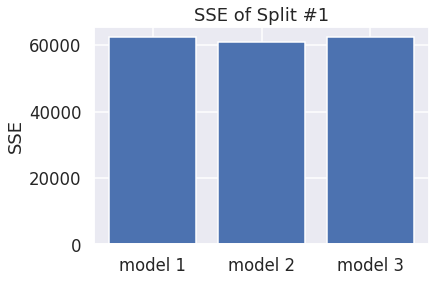

In [0]:
#Model for first training, testing set

print("First training and testing set")
print("Model 1: s.defense = %f + %f*hp + %f*defense + %f*speed \n" % (w1[0],w1[1],w1[2],w1[3]))
print("Model 2: s.defense = %f + %f*hp + %f*hp^2 + %f*defense + \n \
%f*defense^2 + %f*speed + %f*speed^2 \n" % (w2[0],w2[1],w2[2],w2[3],w2[4],w2[5],w2[6]))
print("Model 3: s.defense = %f + %f*hp + %f*defense + %f*speed + \n \
%f*hp*defense + %f*hp*speed + %f*defense*speed" % (w3[0],w3[1],w3[2],w3[3],w3[4],w3[5],w3[6]))
plt.bar(["model 1","model 2", "model 3"],[SSE_test11, SSE_test21, SSE_test31])
plt.ylabel("SSE")
plt.title("SSE of Split #1")
print("\nSSE_test1:", SSE_test11, "\nSSE_test2:", SSE_test21, "\nSSE_test3:", SSE_test31)
plt.show()

Second training and testing set
Model 1: s.defense = 9.238354 + 0.281296*hp + 0.389170*defense + 0.204420*speed 

Model 2: s.defense = -6.895276 + 0.118630*hp + 0.000760*hp^2 + 0.777981*defense + 
 -0.002073*defense^2 + 0.467941*speed + -0.001835*speed^2 

Model 3: s.defense = 5.424525 + 0.418885*hp + 0.500522*defense + 0.081257*speed + 
 -0.002755*hp*defense + 0.000272*hp*speed + 0.001544*defense*speed

SSE_test1: 79323.38235610911 
SSE_test2: 87476.81149496618 
SSE_test3: 77556.84198600643


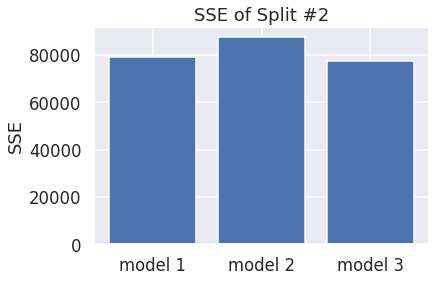

In [0]:
#model for second training,test set

print("Second training and testing set")
print("Model 1: s.defense = %f + %f*hp + %f*defense + %f*speed \n" % (w12[0],w12[1],w12[2],w12[3]))
print("Model 2: s.defense = %f + %f*hp + %f*hp^2 + %f*defense + \n \
%f*defense^2 + %f*speed + %f*speed^2 \n" % (w22[0],w22[1],w22[2],w22[3],w22[4],w22[5],w22[6]))
print("Model 3: s.defense = %f + %f*hp + %f*defense + %f*speed + \n \
%f*hp*defense + %f*hp*speed + %f*defense*speed" % (w32[0],w32[1],w32[2],w32[3],w32[4],w32[5],w32[6]))
plt.bar(["model 1","model 2", "model 3"],[SSE_test12, SSE_test22, SSE_test32])
plt.ylabel("SSE")
plt.title("SSE of Split #2")
print("\nSSE_test1:", SSE_test12, "\nSSE_test2:", SSE_test22, "\nSSE_test3:", SSE_test32)

Third training and testing set
Model 1: s.defense = 9.608260 + 0.270239*hp + 0.409876*defense + 0.199401*speed 

Model 2: s.defense = 2.112712 + 0.048542*hp + 0.001072*hp^2 + 0.670893*defense + 
 -0.001273*defense^2 + 0.392654*speed + -0.001316*speed^2 

Model 3: s.defense = 3.659380 + 0.329839*hp + 0.699190*defense + 0.036856*speed + 
 -0.004023*hp*defense + 0.003059*hp*speed + -0.000399*defense*speed

SSE_test1: 58731.31501363289 
SSE_test2: 60529.960497924134 
SSE_test3: 61097.93200681059


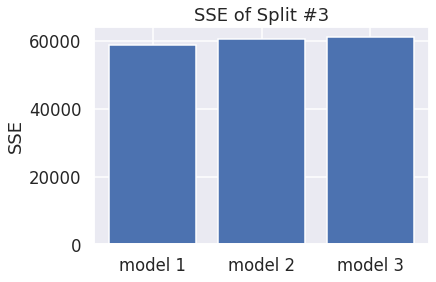

In [0]:
#model for third training,testing set
print("Third training and testing set")
print("Model 1: s.defense = %f + %f*hp + %f*defense + %f*speed \n" % (w13[0],w13[1],w13[2],w13[3]))
print("Model 2: s.defense = %f + %f*hp + %f*hp^2 + %f*defense + \n \
%f*defense^2 + %f*speed + %f*speed^2 \n" % (w23[0],w23[1],w23[2],w23[3],w23[4],w23[5],w23[6]))
print("Model 3: s.defense = %f + %f*hp + %f*defense + %f*speed + \n \
%f*hp*defense + %f*hp*speed + %f*defense*speed" % (w33[0],w33[1],w33[2],w33[3],w33[4],w33[5],w33[6]))
plt.bar(["model 1","model 2", "model 3"],[SSE_test13, SSE_test23, SSE_test33])
plt.ylabel("SSE")
plt.title("SSE of Split #3")
print("\nSSE_test1:", SSE_test13, "\nSSE_test2:", SSE_test23, "\nSSE_test3:", SSE_test33)

Average SSE barplot for all 3 models

SSE_model 1: 66787.5763627838 
SSE_model 2: 69681.90878636915 
SSE_model 3: 67014.56794571139


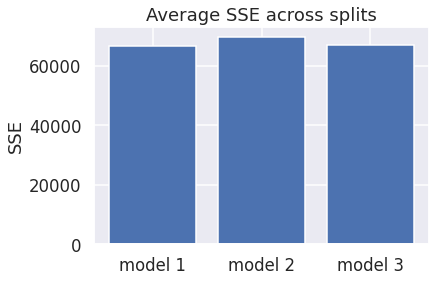

In [0]:
#Barplot for average SSE

print("Average SSE barplot for all 3 models")
SSE1_avg = (SSE_test11 + SSE_test12 + SSE_test13)/3
SSE2_avg = (SSE_test21 + SSE_test22 + SSE_test23)/3
SSE3_avg = (SSE_test31 + SSE_test32 + SSE_test33)/3
plt.bar(["model 1","model 2", "model 3"],[SSE1_avg,SSE2_avg,SSE3_avg])
plt.ylabel("SSE")
plt.title("Average SSE across splits")
print("\nSSE_model 1:", SSE1_avg, "\nSSE_model 2:", SSE2_avg, "\nSSE_model 3:", SSE3_avg)

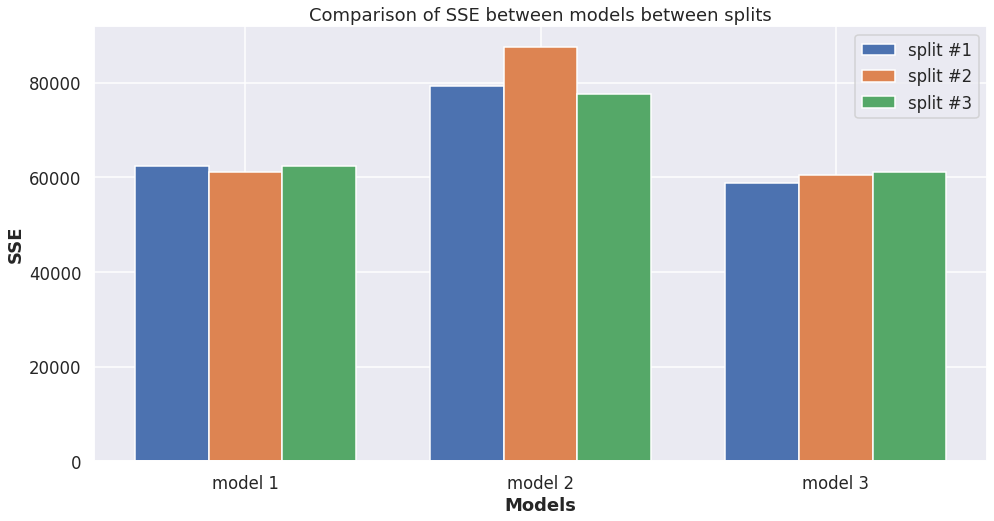

In [0]:
labels_SSE = ['model 1', 'model 2', 'model 3']
model1_SSE = [SSE_test11, SSE_test12, SSE_test13]
model2_SSE = [SSE_test21, SSE_test22, SSE_test23]
model3_SSE = [SSE_test31, SSE_test32, SSE_test33]
average_SSE = [SSE1_avg, SSE2_avg, SSE3_avg]
barWidth = 0.25 

# Set position of bar on X axis
r1 = np.arange(len(model1_SSE))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.figure(figsize=(16,8))
plt.bar(r1, model1_SSE, width=barWidth, edgecolor='white', label='split #1')
plt.bar(r2, model2_SSE, width=barWidth, edgecolor='white', label='split #2')
plt.bar(r3, model3_SSE, width=barWidth, edgecolor='white', label='split #3')
 
# Add xticks on the middle of the group bars
plt.xlabel('Models', fontweight='bold')
plt.ylabel('SSE', fontweight='bold')
plt.title('Comparison of SSE between models between splits')
plt.xticks([r + barWidth for r in range(len(model1_SSE))], labels_SSE)
 
# Create legend & Show graphic
plt.legend()
plt.show()
